In [19]:
import pandas as pd
import numpy as np


pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 100)

## Selection

In [20]:
financial_ratios_table = pd.read_csv('../../DATA/MODEL/transformed_set.csv')

C:\Users\matus.rohal\AppData\Roaming\Python\Python310\site-packages\IPython\core\interactiveshell.py:3433: DtypeWarning: Columns (110) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [21]:
# def sal_class_function(x):
#     if x is None or x != x or x < 50000: return "<50,000"
#     if x < 100000: return "00,050,000 - 100,000"
#     if x < 500000: return "00,100,000 - 500,000"
#     if x < 1000000: return '00,500,000 - 1,000,000'
#     if x < 3000000: return '01,000,000 - 3,000,000'
#     if x < 15000000: return '03,000,000 - 15,000,000'
#     if x < 30000000: return '15,000,000 - 30,000,000'
#     if x < 150000000: return '30,000,000 - 150,000,000'
#     return '>150,000,000'

def sal_class_function(x):
    if x is None or x != x or x <= 50000: return "0. <50,000"
    if x <= 2000000: return "1. Mikro"
    if x <= 10000000: return "2. Malý"
    if x <= 50000000: return "3. Stredný"
    return "4. Veľký"
    
financial_ratios_table['sal_class'] = financial_ratios_table['SAL'].apply(sal_class_function)

In [22]:
financial_ratios_table['sknace_division'] = financial_ratios_table['sknace_division'].fillna('-')

## Outliers

In [23]:

FINANCIAL_RATIOS = [
    'L3', 'L2', 'L1', 'CF_CL', 'CASH_TA', 'SAL_TA', 'TL_SAL',
    'INV_COST', 'INV_SAL', 'CC_SAL', 'TA_SAL',
    'TL_TA', 'CF_TL', 'CL_TA', 'NCL_TA', 'EQ_TL',
    'EQ_TA', 
    'CL_CC', 'ROE', 'EAT_TA',
    'ROA_BRUTTO', 'CF_TA', 'CF_SAL', 'ROS',
    'EAT_YIE', 'ROI', 'ROA_NETTO',
    'LABOR_PRODUCTIVITY']

PRIMARY_METRICS = [
    'CA',
    'CASH',
    'CL', 'EQ', 'NCL', 'TA', 'TL', 'CC',
    'INV',
    'CF_NETTO',
    'CF_SELFFIN',
    'EAT',
    'EBIT',
    'SAL', 'COST',
    'INT', 'YIE', 
]

SKNACE_DIVISIONS =  sorted(list(financial_ratios_table['sknace_division'].unique()))
YEARS = sorted(list(financial_ratios_table['year'].unique()))
SAL_CLASSES =  sorted(list(financial_ratios_table['sal_class'].unique()))
TEMPLATES = list(financial_ratios_table['financial_report_template_id'].unique())

In [24]:
financial_ratios_table['establishment_year'] = pd.to_datetime(financial_ratios_table['establishment_date'], errors='coerce').dt.year

In [25]:
financial_ratios_table['establishment_year']

financial_ratios_table['years_since_est'] = financial_ratios_table['year'] - financial_ratios_table['establishment_year']
financial_ratios_table.query('years_since_est > 1', inplace=True)
financial_ratios_table.drop(columns=['years_since_est'], inplace=True)

In [26]:
financial_ratios_table.query('SAL >= 0 and CA >= 0 and TL >= 0 and CASH >= 0 and NCL >= 0 and total_equity_and_liabilities == total_assets', inplace=True)
financial_ratios_table.query('ownership_category_code in [2, 7, 8] and sknace_division in ["G","M","C","F","N","L","J","H","Q","I","A"] and establishment_date <= "2013-01-01"', inplace=True)

In [27]:
# financial_ratios_table_2018 = financial_ratios_table.query('year == 2018')
# for sal_class in SAL_CLASSES:
#     description_table = financial_ratios_table_2018.query('sal_class == @sal_class')[FINANCIAL_RATIOS].describe().T.sort_values('count')
#     sample_size = financial_ratios_table_2018.query('sal_class == @sal_class').shape[0]
#     description_table['share'] = description_table['count'] / sample_size
#     display(description_table)


In [28]:
from sklearn.impute import SimpleImputer


def fill_missing_values_mean(data):
    # Instantiate SimpleImputer with mean strategy
    imputer = SimpleImputer(strategy='mean')

    # Fit the imputer on the data and transform the data
    imputed_data = imputer.fit_transform(data)

    return imputed_data


In [29]:
import sys

def mahalanobis_distance(data):
    """
    Calculate Mahalanobis Distance for each data point in a multivariate dataset.
    
    # Parameters:
        data (DataFrame): Input DataFrame containing numerical columns.
        
    Returns:
        distances (Series): Mahalanobis Distance for each data point.
    """

    data = data.drop(columns = ['L2'])

    filled_data = fill_missing_values_mean(data)
    if filled_data.shape != data.shape:
        display(data)
        display(filled_data)
    normalized_data = pd.DataFrame(filled_data, columns=data.columns, index=data.index)
    # Normalize the data
    # normalized_data = (imputed_data - imputed_data.mean()) / imputed_data.std()

    # Calculate mean vector
    mean_vector = normalized_data.mean()

    # Calculate covariance matrix
    covariance_matrix = normalized_data.cov()

    # Check if covariance matrix is singular
    if np.linalg.cond(covariance_matrix) > 1/sys.float_info.epsilon:
        # Covariance matrix is singular, apply regularization
        regularization = 1e-6  # Adjust regularization parameter as needed
        covariance_matrix += regularization * np.eye(len(data.columns))

    # Calculate inverse covariance matrix
    try:
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)

        # Calculate Mahalanobis Distance for each data point
        distances = []
        for index, row in normalized_data.iterrows():
            diff = row - mean_vector
            distance = np.sqrt(np.abs(diff.dot(inv_covariance_matrix).dot(diff)))
            distances.append(distance)

        return pd.Series(distances, index=data.index)
    
    except np.linalg.LinAlgError:
        display(data.shape)
        display(data)
        display(normalized_data)

def flag_outliers_mahalanobis(data, threshold=2):
    # Calculate Mahalanobis Distance for each data point
    distances = mahalanobis_distance(data)

    # Determine threshold based on chi-square distribution
    chi2_threshold = threshold ** 2
    try:
        cutoff = np.percentile(distances, 100 * (1 - np.exp(-chi2_threshold / 2)))

        # Flag outliers
        outliers = distances > cutoff

        return outliers
    except TypeError:
        print(chi2_threshold)
        print(threshold)
        display(distances)
        display(data)

outlier_boolean_1 = pd.DataFrame()
for year in YEARS:
    for sal_class in SAL_CLASSES:
        for sknace in SKNACE_DIVISIONS:
            subset = financial_ratios_table.query('period_length == 12 and sal_class == @sal_class and year == @year and sknace_division == @sknace').set_index(['financial_statement_id'])[FINANCIAL_RATIOS]
            if subset.shape[0] < 5:
                outlier_boolean_1 = pd.concat([
                    outlier_boolean_1,
                    subset.reset_index()[['financial_statement_id']]
                ], axis=0)
                continue
            outlier_boolean_1 = pd.concat([
                outlier_boolean_1,
                flag_outliers_mahalanobis(subset).to_frame(name = 'is_outlier').reset_index()
            ], axis=0)
        
display(outlier_boolean_1['is_outlier'].value_counts())



False    785121
True     122972
Name: is_outlier, dtype: int64

In [30]:
display(financial_ratios_table.shape)

financial_ratios_table = financial_ratios_table.merge(outlier_boolean_1, on = ['financial_statement_id'], how = 'left')

display(financial_ratios_table.shape)
display(financial_ratios_table)

(921211, 135)

(921211, 136)

,entity_id,year,month,financial_report_id,financial_report_template_id,total_assets,non_current_assets,non_current_intangible_assets,non_current_tangible_assets,non_current_financial_assets,current_assets,inventories,non_current_receivables,current_receivables,financial_assets,current_financial_assets,cash_and_bank_balances,total_equity_and_liabilities,equity,share_capital,share_premium,net_profit_of_previous_years,net_profit_after_tax,liabilities,non_current_liabilities,long_term_provisions,long_term_bank_loans,current_liabilities,short_term_provisions,current_bank_loans,short_term_financial_assistance,operating_revenues,sales_from_the_merchandise,sales_from_the_own_products_and_services,sales_from_the_other,other_revenues_from_operating_activities,operating_costs,costs_of_merchandise_sold,consumed_materials_energy_non_inventory_supplies,services,personnel_costs,taxes_and_fees,depreciation,remaining_cost_of_sold_long_term_assets_and_materials,adjustments_to_receivables,other_costs_of_operating_activities,operating_result,value_added,revenues_from_financial_activities,cost_of_financial_activities,result_from_fincancial_activities,result_before_tax,income_tax,result_after_tax,CA,CASH,CL,EQ,NCL,TA,TL,CC,INV,CF_NETTO,CF_SELFFIN,EAT,EBIT,SAL,COST,INT,YIE,LABOR,L3,L2,L1,CF_CL,CASH_TA,SAL_TA,TL_SAL,INV_COST,INV_SAL,CC_SAL,TA_SAL,TL_TA,CF_TL,CL_TA,NCL_TA,EQ_TL,EQ_TA,EBIT_INT,CL_CC,ROE,EAT_TA,ROA_BRUTTO,CF_TA,CF_SAL,ROS,EAT_YIE,ROI,ROA_NETTO,LABOR_PRODUCTIVITY,financial_statement_id,financial_report_order_number,entity_ico,period_length,consolidated,approved_date,type,entity_name,establishment_date,cancellation_date,sknace_code,entity_state,legal_form_code,org_size_code,ownership_category_code,entity_consolidated,sknace_division_name,sknace_division,sknace_subcategory,DPHZ_vat_registration_cancelled,DPHZ_vat_registration_cancelled_1y_off,DPHZ_vat_registration_cancelled_2y_off,DPHZ_vat_registration_cancelled_3y_off,RU_event,RU_event_1y_off,RU_event_2y_off,RU_event_3y_off,cancellation_year,RUZ_cancelled,RUZ_cancelled_1y_off,RUZ_cancelled_2y_off,RUZ_cancelled_3y_off,sal_class,establishment_year,is_outlier
0,4.0,2014.0,1.0,4644773,699.0,11200988.0,1946914.0,14341.0,106669.0,1825904.0,8787618.0,16429.0,953600.0,2578606.0,5238983.0,0.0,5238983.0,11200988.0,2112122.0,39900.0,1143260.0,-78935.0,1007897.0,8657266.0,3232.0,40297.0,0.0,4658457.0,3906138.0,49142.0,0.0,18580340.0,0.0,18416986.0,0.0,163354.0,18172171.0,0.0,117382.0,14389476.0,3384185.0,2946.0,55386.0,0.0,173287.0,49509.0,408169.0,3910128.0,780965.0,73442.0,707523.0,1115692.0,107795.0,1007897.0,8787618.0,5238983.0,4658457.0,2112122.0,3232.0,11200988.0,8657266.0,2578606.0,16429.0,1171078.0,1063283.0,1007897.0,1115692.0,18580340.0,18172171.0,4446.0,19361305.0,3384185.0,1.886380,1.678150,1.124618,0.251388,0.467725,1.658813,0.465937,0.325467,0.318317,0.138781,217.022707,0.772902,0.135271,0.415897,0.000289,0.243971,0.188566,251.942870,1.806580,0.477196,0.089983,0.099607,0.104551,0.063028,0.054245,0.052057,0.090380,0.089983,0.182138,2382229.0,1.0,603783.0,12.0,NaN,2015-07-07,Riadna,"NESS Slovensko, a.s.",1991-01-17,NaN,62090.0,NaN,121.0,11.0,7.0,True,"Počítačové programovanie, poradenstvo a súvisi...",J,62.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0,0,0,0,3. Stredný,1991,False
1,4.0,2015.0,1.0,5382540,699.0,20862929.0,116951.0,14800.0,101401.0,750.0,20276962.0,6792.0,545698.0,14037315.0,5687157.0,0.0,5687157.0,20862929.0,13229589.0,39900.0,1143260.0,5510185.0,6536244.0,7184264.0,2890.0,0.0,0.0,6153737.0,1027637.0,0.0,0.0,17608945.0,0.0,17435113.0,0.0,173832.0,11551924.0,0.0,106101.0,13052044.0,3581817.0,3727.0,-3290982.0,0.0,-46425.0,-1854358.0,6057021.0,4276968.0,11964908.0,10790551.0,1174357.0,7231378.0,695134.0,6536244.0,20276962.0,5687157.0,6153737.0,13229589.0,2890.0,20862929.0,7184264.0,14037315.0,6792.0,3940396.0,3245262.0,6536244.0,7231378.0,17608945.0,11551924.0,2910.0,29573853.0,3581817.0,3.295065,3.205284,0.924179,0.640326,0.272596,0.844030,0.407989,0.211663,0.138857,0.797170,426.5

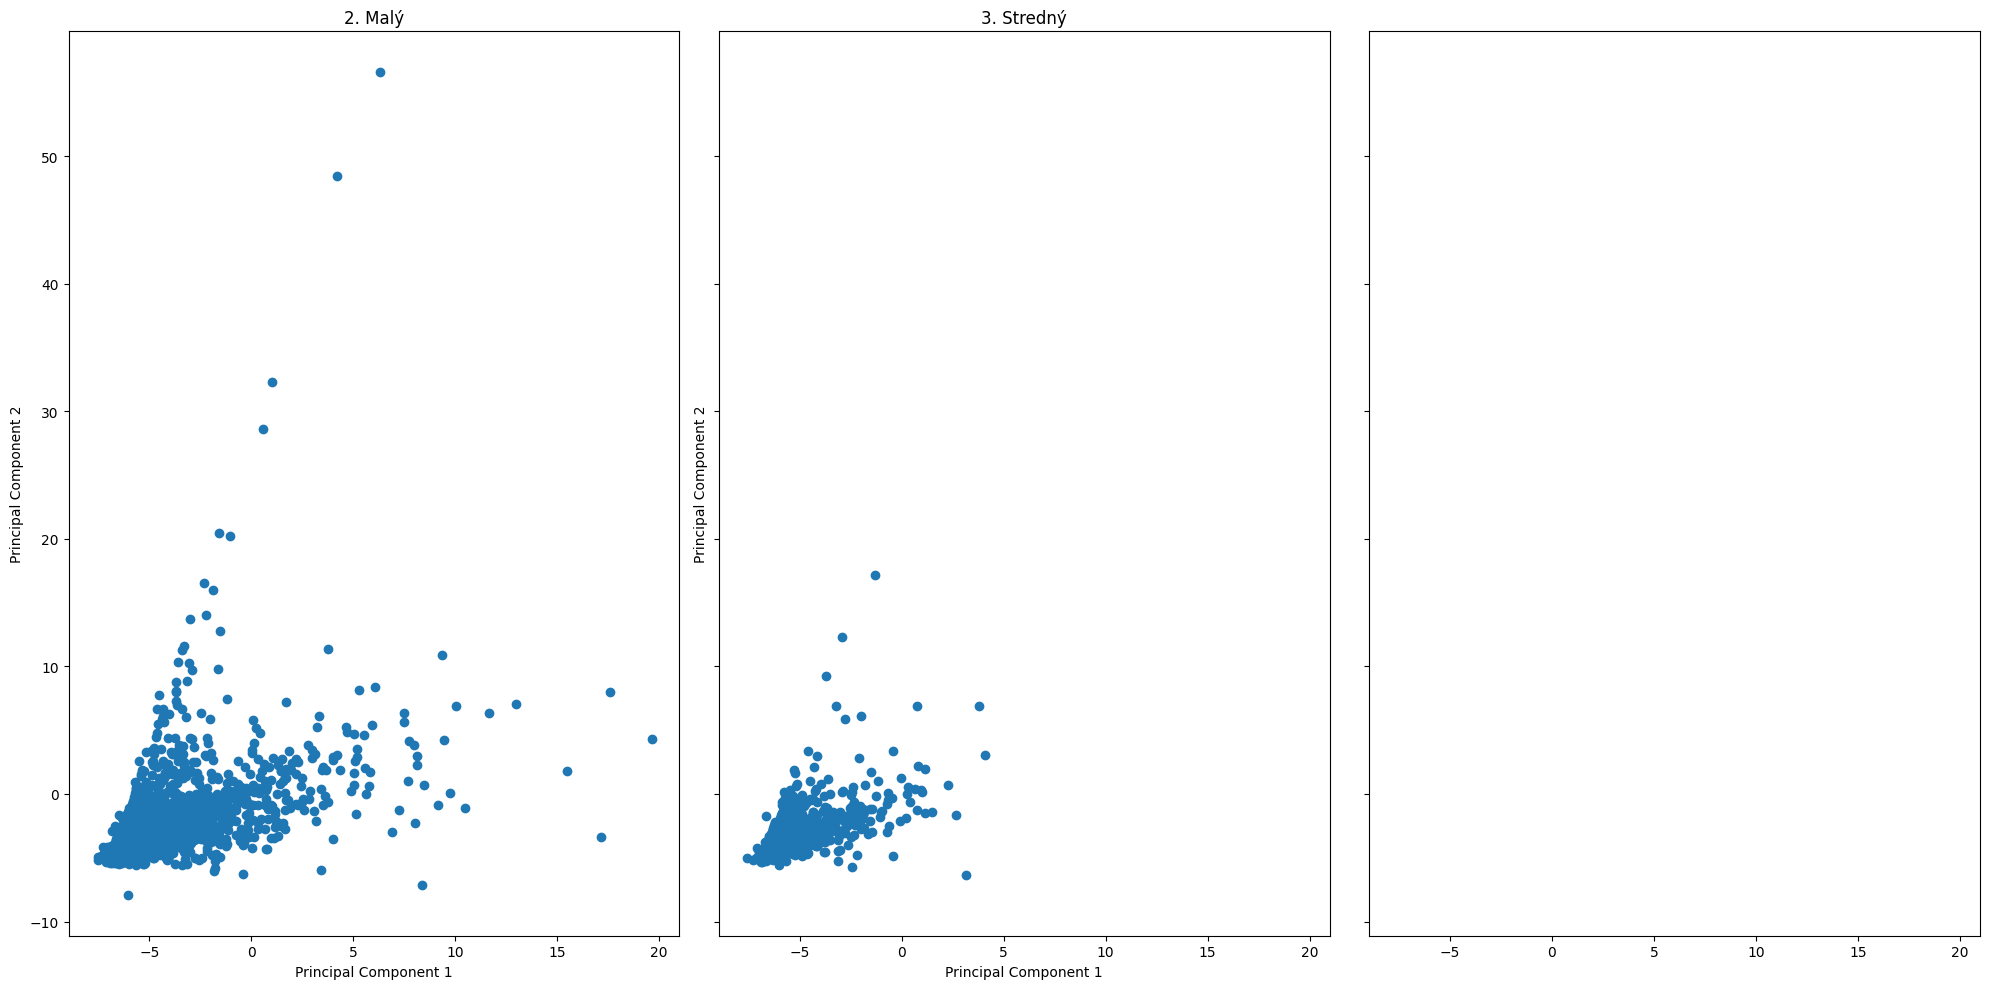

In [31]:
from sklearn.decomposition import PCA
import seaborn as sns
from matplotlib import pyplot as plt


SAL_CLASSES2 = ["2. Malý", "3. Stredný"]

fig, axes = plt.subplots(ncols=3, nrows=len(SAL_CLASSES2) // 3 + 1, sharex=True, sharey=True, figsize=(20, 10))
axes = axes.flatten()

data_group = financial_ratios_table.query('year == 2018 and is_outlier == False')

data = fill_missing_values_mean(data_group[['L3', 'EQ_TL']].values)
            
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)


for i, sknace in enumerate(SAL_CLASSES2):
    ax = axes[i]
    class_indices = data_group['sal_class'] == sknace
    
    ax.scatter(pca_data[class_indices, 0], pca_data[class_indices, 1], label=sknace)

    ax.set_title(f'{sknace}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

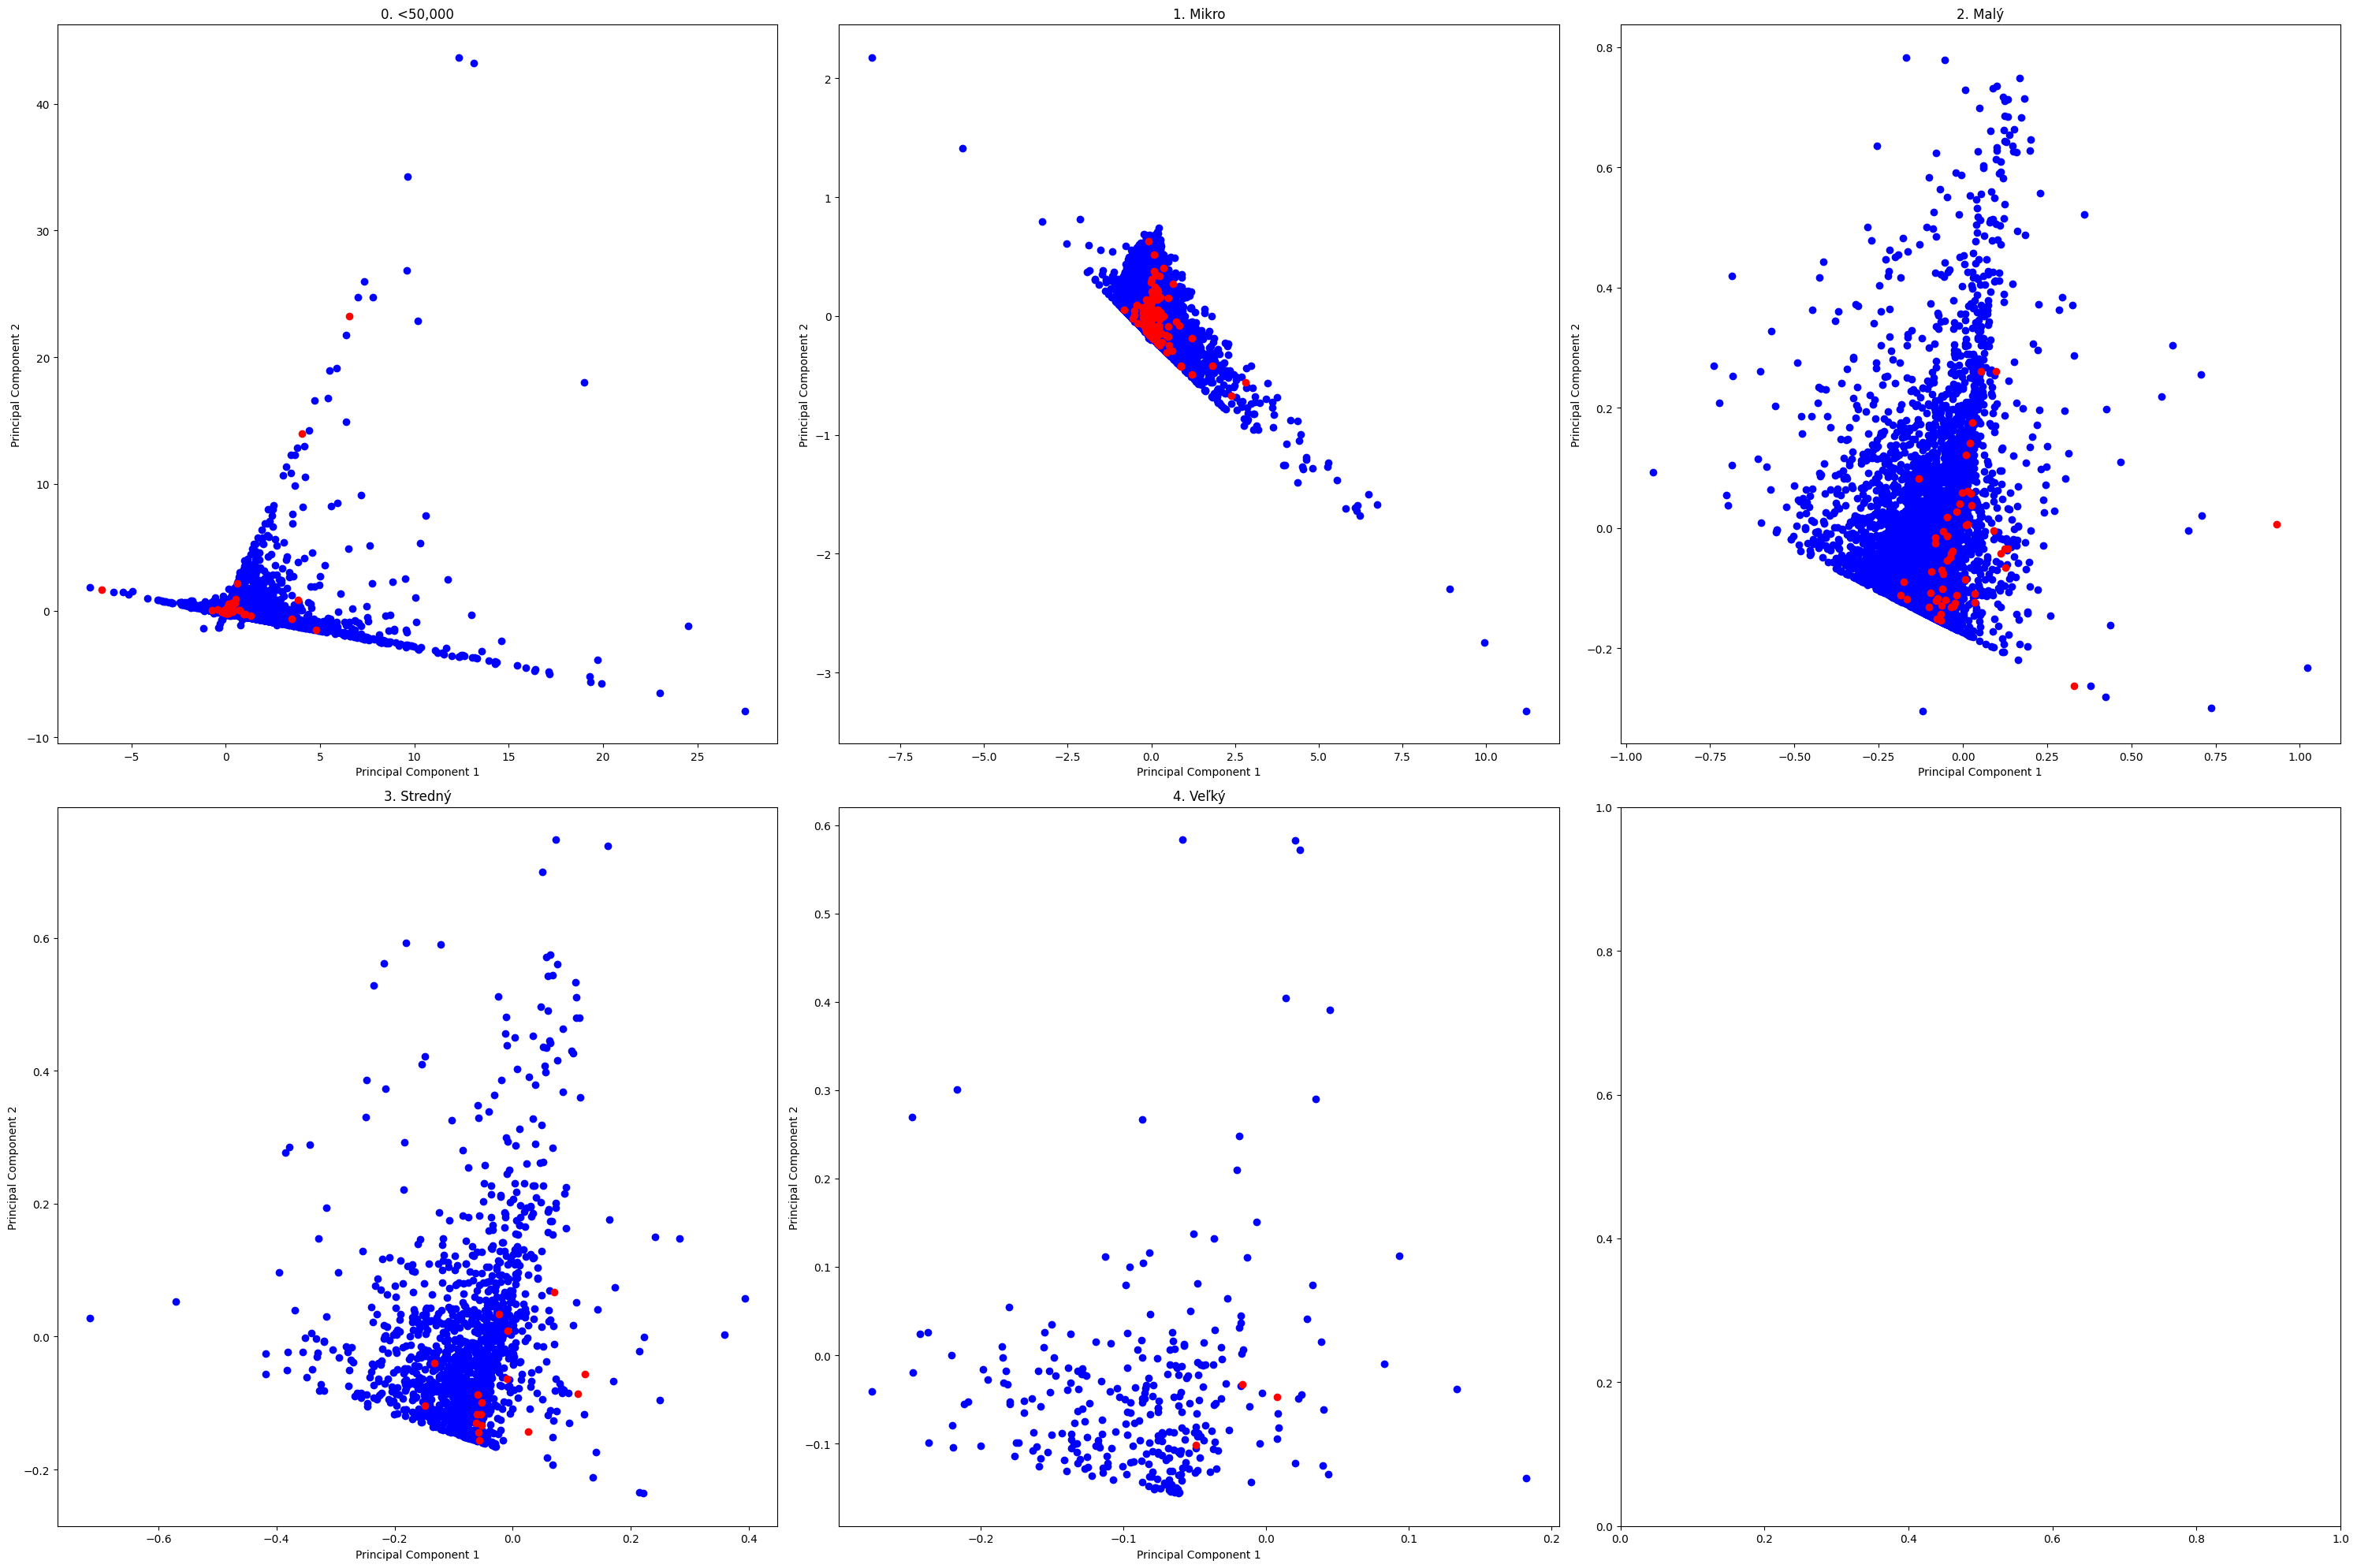

In [32]:
DISTRESS_CRITERIA =  ['DPHZ_vat_registration_cancelled',
 'DPHZ_vat_registration_cancelled_1y_off',
 'DPHZ_vat_registration_cancelled_2y_off',
 'DPHZ_vat_registration_cancelled_3y_off',
 'RU_event',
 'RU_event_1y_off',
 'RU_event_2y_off',
 'RU_event_3y_off',
 'RUZ_cancelled',
 'RUZ_cancelled_1y_off',
 'RUZ_cancelled_2y_off',
 'RUZ_cancelled_3y_off']

DISTRESS_CRITERION = 'RU_event_3y_off'

fig, axes = plt.subplots(ncols=3, nrows=len(SAL_CLASSES) // 3 + 1, figsize=(30, 20))
axes = axes.flatten()

data_group = financial_ratios_table.query('year == 2018 and is_outlier == False and period_length == 12').sort_values(DISTRESS_CRITERION, ascending=True)

data = fill_missing_values_mean(data_group[['EAT_TA', 'LABOR_PRODUCTIVITY']].values)
            
pca = PCA(n_components=2)
pca_data = pca.fit_transform(data)


colors = ['blue', 'red']  # Define colors for RUZ_cancelled categories

for i, sal_class in enumerate(SAL_CLASSES):
    ax = axes[i]
    for j, ruz_cancelled in enumerate([False, True]):
        class_indices = (data_group['sal_class'] == sal_class) & (data_group[DISTRESS_CRITERION] == ruz_cancelled)
        ax.scatter(pca_data[class_indices, 0], pca_data[class_indices, 1], label=f'{DISTRESS_CRITERION}={ruz_cancelled}', color=colors[j])


    ax.set_title(f'{sal_class}')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

In [33]:
financial_ratios_table.to_csv('../../DATA/FINAL/transformed_set_enriched.csv', index = False)